# generate 1D test data

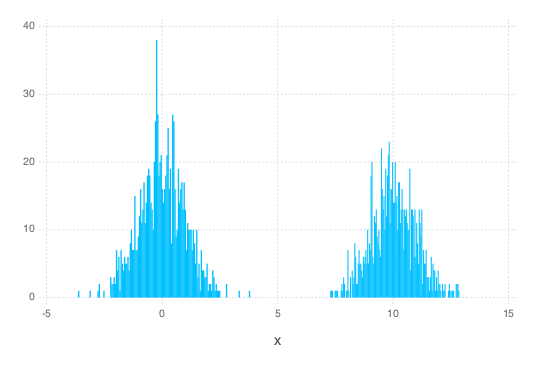

In [71]:
using Gadfly

N = 1000

X = randn(N)
Y = randn(N) + 10

plot(   layer(x = X, Geom.histogram),
layer(x = Y, Geom.histogram))

# construct SPN

In [72]:
#using SPN
using Distributions
include("../src/SPN.jl")

root = SPN.SumNode(0)

SPN.add!(root, SPN.UnivariateNode(fit(Normal, X)))
SPN.add!(root, SPN.UnivariateNode(fit(Normal, Y)))

SPN.normalize!(root);

SPN.order(root)

3-element Array{SPN.SPNNode,1}:
 SPN.UnivariateNode(Distributions.Normal(μ=0.009341756889642002, σ=0.9919949857293877),0)                                                                                                                                                      
 SPN.UnivariateNode(Distributions.Normal(μ=10.02972504791799, σ=0.9756983427841868),0)                                                                                                                                                         
 SPN.SumNode(0,SPN.SPNNode[SPN.UnivariateNode(Distributions.Normal(μ=0.009341756889642002, σ=0.9919949857293877),0),SPN.UnivariateNode(Distributions.Normal(μ=10.02972504791799, σ=0.9756983427841868),0)],Float32[0.8483617f0,0.15163831f0],0)

## test

In [73]:
using Base.Test

N = 100

X = randn(N)

root = SPN.SumNode(0)
SPN.add!(root, SPN.UnivariateNode(fit(Normal, X)))
SPN.normalize!(root);

@test length(root.children) == 1
@test root.weights[1] == 1.0
@test SPN.order(root)[end] == root

In [74]:
@time SPN.order(root);

  0.000061 seconds (34 allocations: 1.469 KB)


## compute llh

In [75]:
root = SPN.SumNode(0)

SPN.add!(root, SPN.UnivariateNode(fit(Normal, X)))
SPN.add!(root, SPN.UnivariateNode(fit(Normal, Y)))

SPN.normalize!(root);

SPN.llh(root, [5.0])
@time SPN.llh(root, [5.0]);

  0.000221 seconds (137 allocations: 6.891 KB)


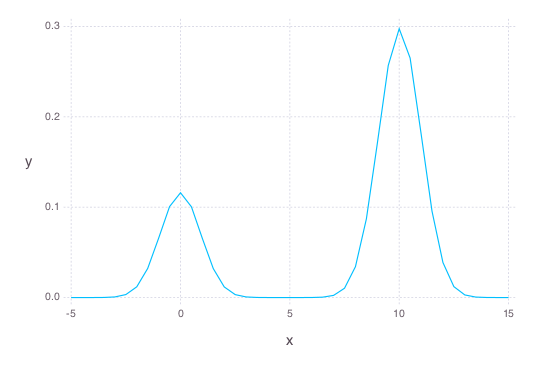

0.000249 seconds (218 allocations: 19.391 KB)


In [76]:
x = -5:0.5:15
p = zeros(length(x))

p = SPN.llh(root, collect(x))

@time SPN.llh(root, collect(x))

plot( x = x, y = exp(p), Geom.line )

# generate 2D test data

0.000213 seconds (137 allocations: 6.891 KB)
  0.000234 seconds (218 allocations: 19.391 KB)


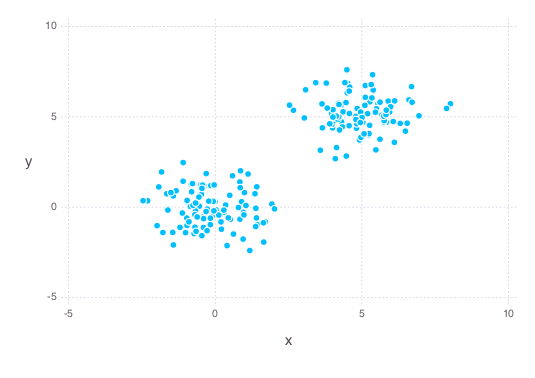

In [65]:
N = 100

X1 = randn(2, N)
X2 = 5 + randn(2, N)

X = cat(2, X1, X2)

plot(x = X[1,:], y = X[2,:], Geom.point)

In [66]:
root = SPN.SumNode(0)

pnode1 = SPN.ProductNode(1)

SPN.add!(pnode1, SPN.UnivariateNode(fit(Normal, X1[1,:]), 1))
SPN.add!(pnode1, SPN.UnivariateNode(fit(Normal, X1[2,:]), 2))

pnode2 = SPN.ProductNode(2)

SPN.add!(pnode2, SPN.UnivariateNode(fit(Normal, X2[1,:]), 1))
SPN.add!(pnode2, SPN.UnivariateNode(fit(Normal, X2[2,:]), 2))

SPN.add!(root, pnode1)
SPN.add!(root, pnode2)

SPN.SumNode(0,SPN.SPNNode[SPN.ProductNode(1,SPN.SPNNode[SPN.UnivariateNode(Distributions.Normal(μ=-0.16970585314931896, σ=1.0136555563503078),1),SPN.UnivariateNode(Distributions.Normal(μ=-0.05476867785599387, σ=1.0252201211081953),2)],Nullable{SPN.ClassNode}()),SPN.ProductNode(2,SPN.SPNNode[SPN.UnivariateNode(Distributions.Normal(μ=4.980876777351714, σ=0.997045170836496),1),SPN.UnivariateNode(Distributions.Normal(μ=5.159088247265609, σ=0.9554165174233317),2)],Nullable{SPN.ClassNode}())],Float32[0.27243873f0,0.9666316f0],0)

In [67]:
x = [0.0 0.0; 0.3 0.5; 0.4 0.1]'

SPN.llh(root, x)

1x3 Array{Float64,2}:
 -3.40649  -3.64482  -3.56038

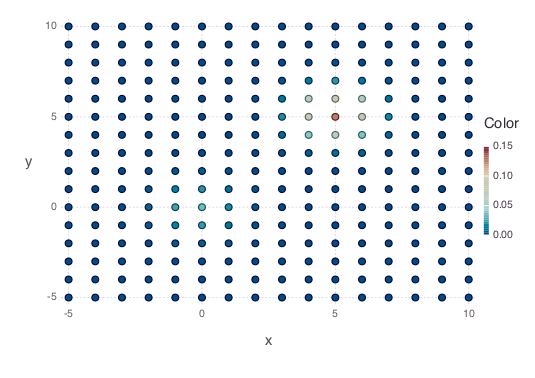

In [68]:
x = -5:10
X = zeros(2, length(x) ^ 2)

for (ii, i) in enumerate(x)
    for (jj, j) in enumerate(x)
        
        ix = ii - 1
        
        X[1,jj + ix*(length(x))] = i
        X[2,jj + ix*(length(x))] = j
    end
end

p = SPN.llh(root, X)

plot(x = X[1,:], y = X[2,:], color=exp(p), Geom.point)

## use multivariate nodes

In [69]:
using BNP
using Distributions

D = 2

μ0 = vec( zeros(D) )
κ0 = 1.0
ν0 = convert(Float64, D)
Ψ = eye(D) * 10

d = GaussianWishart(μ0, κ0, ν0, Ψ);

println(SPN.MultivariateNode{ConjugatePostDistribution}(d, collect(1:2)))

# Distributions version

d = MvNormal(zeros(D), eye(D))
n = SPN.MultivariateNode{ContinuousMultivariateDistribution}(d, collect(1:2))

println(n)

SPN.eval(n, zeros(D, 1), Dict{SPN.SPNNode, Array{Float64}}());

SPN.MultivariateNode{BNP.ConjugatePostDistribution}(BNP.GaussianWishart(2,0,[0.0,0.0],[0.0 0.0
 0.0 0.0],[0.0,0.0],1.0,2.0,[10.0 0.0
 0.0 10.0]),[1,2])
SPN.MultivariateNode{Distributions.Distribution{Distributions.Multivariate,Distributions.Continuous}}(FullNormal(
dim: 2
μ: [0.0,0.0]
Σ: [1.0 0.0
 0.0 1.0]
)
,[1,2])


# compute MAP

In [70]:
(v, path) = SPN.map(root, zeros(2, 1))

for key in keys(path)
    
    for c in path[key]    
        if isa(c, SPN.Leaf)
            println(c)
        end
    end
end

SPN.UnivariateNode(Distributions.Normal(μ=-0.16970585314931896, σ=1.0136555563503078),1)
SPN.UnivariateNode(Distributions.Normal(μ=-0.05476867785599387, σ=1.0252201211081953),2)
